# Fake News Detection Assignment
**Objective**:

Develop machine learning models to accurately detect fake news. Utilize various algorithms including Decision Tree, Random Forest, XGBoost, ExtraTrees, and LightGBM.

**Dataset**:

[Fake News Dataset from Kaggle](https://www.kaggle.com/c/fake-news/data).

**Steps**:

* Data Loading: Load the dataset using Pandas.
* Preprocessing: Clean and preprocess the text data.
* Feature Extraction: Convert text to numerical data using TF-IDF.
* Data Splitting: Split the dataset into training and testing sets.
* Model Training: Train the models on the training set.
* Evaluation: Evaluate the models using accuracy on the test set.

## Step 1: Loading the Data


In [ ]:
# In the first step, I upload my JSON file to download the dataset.


# Make sure the kaggle.json is present.
!ls -lha kaggle.json

# Install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# download dataset from competitions
!kaggle competitions download -c fake-news

-rw-r--r-- 1 root root 72 Jan 14 13:30 kaggle.json
 97% 45.0M/46.5M [00:00<00:00, 62.1MB/s]
100% 46.5M/46.5M [00:00<00:00, 52.6MB/s]


In [ ]:
# unzip the file
!unzip fake-news.zip

Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/train.csv')

In [ ]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Step 2: Text Preprocessing


In [ ]:
# drop id and author column
data.drop(['id', 'author'], axis=1, inplace=True)

In [ ]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
title,20242,19803,Get Ready For Civil Unrest: Survey Finds That ...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,20761,20386,,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,20800.0,NaN,NaN,NaN,0.500625,0.500012,0.0,0.0,1.0,1.0,1.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   text    20761 non-null  object
 2   label   20800 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 487.6+ KB


In [ ]:
# check and drop duplicated instances
print('duplicated records: ', data.duplicated().sum())
data = data.drop_duplicates()

duplicated records:  110


In [ ]:
# checking null values
print('null values:\n',data.isnull().sum())
data['text'] = data['text'].fillna('No Text')
data['title'] = data['title'].fillna('No title')
print('checking again null values:\n',data.isnull().sum());

null values:
 title    518
text      39
label      0
dtype: int64
checking again null values:
 title    0
text     0
label    0
dtype: int64


In [ ]:
data['label'].value_counts()

0    10387
1    10303
Name: label, dtype: int64

Dataset is balance

In [ ]:
# Feature engineering: create a new feature by combining the title and text
data["new_text"] = data["title"] + " " + data["text"]

In [ ]:
data.head()

,title,text,label,new_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [ ]:
data.drop(['title', 'text'], axis=1, inplace=True)

In [ ]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Function to clean the text
def clean_text(text):
  # keep only the letters (normalizing)
  text = re.sub('[^a-zA-Z]', ' ', text)
  # make the text lower then split it
  text = text.lower().split()
  # just uncomment the following line and think about what you are doing
  ps = PorterStemmer()
  text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
  text = ' '.join(text)
  return text

In [ ]:
# Apply the cleaning function to your text data column
data['processed_text'] = data['new_text'].apply(clean_text)

## Step 3: Feature Extraction


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract features with 5000 features
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['processed_text']).toarray()
y = data['label']

## Step 4: Splitting the Data


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Step 5: Model Training
### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

### Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### ExtraTrees


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

et_classifier = ExtraTreesClassifier()
et_classifier.fit(X_train, y_train)

ExtraTreesClassifier()

### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

lgb_classifier = LGBMClassifier()
lgb_classifier.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 8242, number of negative: 8310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.880462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669173
[LightGBM] [Info] Number of data points in the train set: 16552, number of used features: 4996
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497946 -> initscore=-0.008217
[LightGBM] [Info] Start training from score -0.008217


LGBMClassifier()

## Step 6: Evaluation


In [ ]:
from sklearn.metrics import accuracy_score

# Example for Random Forest
predictions = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9550507491541808


## Step 7: Comparing Model Performance using ROC AUC Score


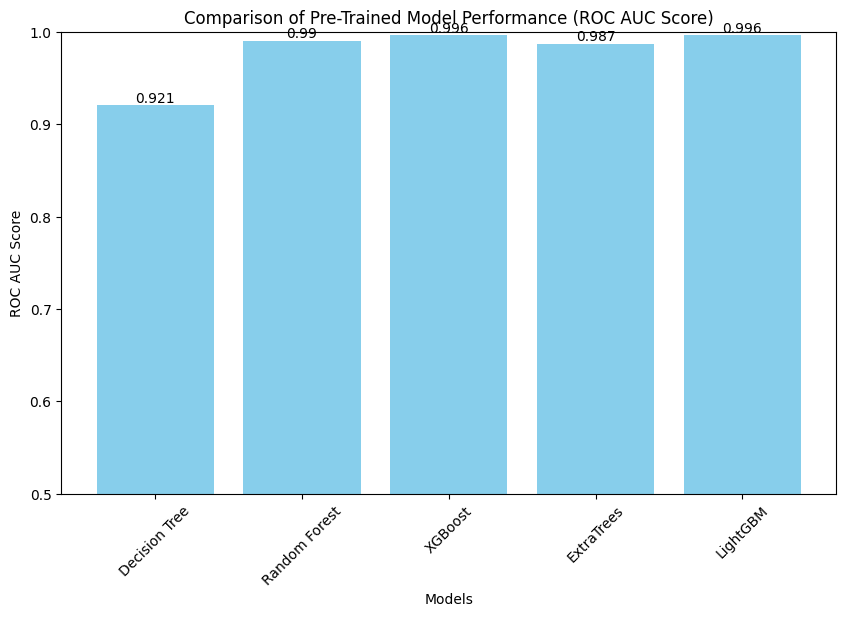

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Function to evaluate a pre-trained model and return its ROC AUC score
def evaluate_pretrained_model(model, X_test, y_test):
    predictions = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, predictions)
    return roc_auc

# Dictionary of your pre-trained models
pretrained_models = {
    "Decision Tree": dt_classifier,  # Replace with your pre-trained decision tree model variable
    "Random Forest": rf_classifier,  # Replace with your pre-trained random forest model variable
    "XGBoost": xgb_classifier,       # Replace with your pre-trained XGBoost model variable
    "ExtraTrees": et_classifier,     # Replace with your pre-trained ExtraTrees model variable
    "LightGBM": lgb_classifier       # Replace with your pre-trained LightGBM model variable
}

# Evaluate each pre-trained model and store results
roc_auc_scores = {name: evaluate_pretrained_model(model, X_test, y_test) for name, model in pretrained_models.items()}

# Plotting the results
plt.figure(figsize=(10, 6))
bars = plt.bar(roc_auc_scores.keys(), roc_auc_scores.values(), color='skyblue')

for bar, value in zip(bars, roc_auc_scores.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, value, round(value, 3), ha='center', va='bottom')

# xlabel or xticks?
plt.xlabel('Models')
# ylabel or yticks?
plt.ylabel('ROC AUC Score')
plt.title('Comparison of Pre-Trained Model Performance (ROC AUC Score)')
plt.ylim([0.5, 1.0])  # Adjust based on your ROC AUC score range
# xlabel or xticks?
plt.xticks(rotation=45)
# how show the diagram?
plt.show()

# Create submission file

In [ ]:
test = pd.read_csv('/content/test.csv')

In [ ]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


In [ ]:
test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,5200.0,NaN,NaN,NaN,23399.5,1501.255031,20800.0,22099.75,23399.5,24699.25,25999.0
title,5078,5056,Get Ready For Civil Unrest: Survey Finds That ...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,4697,1732,Pam Key,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,5193,5126,,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('null values:\n',test.isnull().sum())
test['text'] = test['text'].fillna('No Text')
test['title'] = test['title'].fillna('No title')
print('checking again null values:\n',test.isnull().sum());

null values:
 id          0
title     122
author    503
text        7
dtype: int64
checking again null values:
 id          0
title       0
author    503
text        0
dtype: int64


In [ ]:
test["new_text"] = test["title"] + " " + test["text"]

In [ ]:
# drop id and author column
test.drop(['author', 'title', 'text'], axis=1, inplace=True)

In [ ]:
test

,id,new_text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse..."
1,20801,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ..."
4,20804,Keiser Report: Meme Wars (E995) 42 mins ago 1 ...
...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...
5197,25997,"California Today: What, Exactly, Is in Your Su..."
5198,25998,300 US Marines To Be Deployed To Russian Borde...


In [ ]:
# Apply the cleaning function to your text data column
test['processed_text'] = test['new_text'].apply(clean_text)

In [ ]:
# Extract features with 5000 features
X_new_test = tfidf.transform(test['processed_text']).toarray()

In [ ]:
# best model among xgb and LightGBM
# Example for Random Forest
predictions_xgb = xgb_classifier.predict(X_test)
predictions_lgb = lgb_classifier.predict(X_test)

accuracy_xgb = accuracy_score(y_test, predictions_xgb)
accuracy_lgb = accuracy_score(y_test, predictions_lgb)

print(f'Accuracy in xgb: {accuracy_xgb}')
print(f'Accuracy in lgb: {accuracy_lgb}')

Accuracy in xgb: 0.9695505074915418
Accuracy in lgb: 0.9695505074915418


In [ ]:
# Prediction
pred = xgb_classifier.predict(X_new_test)

In [ ]:
output = pd.DataFrame({'id': test.id, 'label': pred})
output.to_csv('submission.csv', index=False)